In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
num_batches = 32

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=num_batches,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=num_batches,
                                        shuffle=False, num_workers=2)

# 분류 결과를 위한 상수
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [3]:
# 이미지를 보여주기 위한 헬퍼(helper) 함수
# (아래 `plot_classes_preds` 함수에서 사용)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
data = next(iter(trainloader))
img, label = data

In [5]:
img.size() # batch_size, num_channel, x, y

torch.Size([32, 1, 28, 28])

In [6]:
label.size() # 0~9까지의 숫자가 batch_size 만큼

torch.Size([32])

In [7]:
use_cuda = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
#         # gpu로 할당
#         if use_cuda:
#             self.conv_module = self.conv_module.cuda()
#             self.fc_module = self.fc_module.cuda()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
# loss
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./runs/

logdir="runs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# 기본 `log_dir` 은 "runs"이며, 여기서는 더 구체적으로 지정하였습니다
writer = SummaryWriter(logdir)

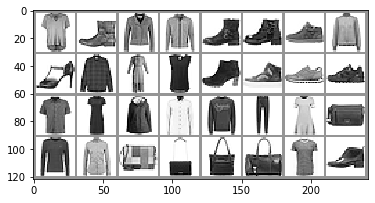

In [11]:
# add "images" to tensorboard

# 임의의 학습 이미지를 가져옵니다
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 그리드를 만듭니다.
img_grid = torchvision.utils.make_grid(images)

# 이미지를 보여줍니다.
matplotlib_imshow(img_grid, one_channel=True)

# tensorboard에 기록합니다.
writer.add_image('four_fashion_mnist_images', img_grid)

In [12]:
# add "graphs" to tensorboard
writer.add_graph(net, images)
writer.close()

In [13]:
# 헬퍼 함수

def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지 / 라벨을 사용하여 matplotlib
    Figure를 생성합니다. 이는 신경망의 예측 결과 / 확률과 함께 정답을 보여주며,
    예측 결과가 맞았는지 여부에 따라 색을 다르게 표시합니다. "images_to_probs"
    함수를 사용합니다.
    '''
    preds, probs = images_to_probs(net, images)
    # 배치에서 이미지를 가져와 예측 결과 / 정답과 함께 표시(plot)합니다
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [14]:
num_epochs = 3

trn_loss_list = []
val_loss_list = []


for epoch in range(num_epochs):  # 데이터셋을 여러번 반복
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # del (memory issue)
        del loss
        del outputs
        
        # 학습과정 출력
        if (i+1) % 500 == 0: # every 500 mini-batches
            with torch.no_grad(): # very very very very important!!!
                val_loss = 0.0
                for j, val in enumerate(testloader):
                    val_x, val_label = val
                    if use_cuda:
                        val_x = val_x.cuda()
                        val_label =val_label.cuda()
                    val_output = net(val_x)
                    v_loss = criterion(val_output, val_label)
                    val_loss += v_loss
                    
            del val_output
            del v_loss
            
            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, running_loss / 100, val_loss / len(testloader)
            ))            
            
            trn_loss_list.append(running_loss/100)
            val_loss_list.append(val_loss/len(testloader))
        

            # ...학습 중 손실(running loss)을 기록하고
            writer.add_scalar('training loss', running_loss / 1000,
                              epoch * len(trainloader) + i)

            # ...무작위 미니배치(mini-batch)에 대한 모델의 예측 결과를 보여주도록
            # Matplotlib Figure를 기록합니다
            writer.add_figure('predictions vs. actuals',
                              plot_classes_preds(net, inputs, labels),
                              global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
            
            
print('Finished Training')

epoch: 1/3 | step: 500/32 | trn loss: 11.1721 | val loss: 1.8610
epoch: 1/3 | step: 1000/32 | trn loss: 5.2969 | val loss: 0.8232
epoch: 1/3 | step: 1500/32 | trn loss: 3.6972 | val loss: 0.7680
epoch: 2/3 | step: 500/32 | trn loss: 3.0827 | val loss: 0.6545
epoch: 2/3 | step: 1000/32 | trn loss: 2.9179 | val loss: 0.5981
epoch: 2/3 | step: 1500/32 | trn loss: 2.8568 | val loss: 0.5723
epoch: 3/3 | step: 500/32 | trn loss: 2.6035 | val loss: 0.5164
epoch: 3/3 | step: 1000/32 | trn loss: 2.4851 | val loss: 0.5256
epoch: 3/3 | step: 1500/32 | trn loss: 2.4200 | val loss: 0.5062
Finished Training


In [15]:
# val acc
with torch.no_grad():
    corr_num = 0
    total_num = 0
    for j, val in enumerate(testloader):
        val_x, val_label = val
        if use_cuda:
            val_x = val_x.cuda()
            val_label =val_label.cuda()
        val_output = net(val_x)
        model_label = val_output.argmax(dim=1)
        corr = val_label[val_label == model_label].size(0)
        corr_num += corr
        total_num += val_label.size(0)

print("acc: {:.2f}".format(corr_num / total_num * 100))

acc: 81.84


In [16]:
# 1. 예측 확률을 test_size x num_classes 텐서로 가져옵니다
# 2. 예측 결과를 test_size 텐서로 가져옵니다
# 실행하는데 10초 이하 소요
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

In [17]:
%tensorboard --logdir=runs

Launching TensorBoard...